In [1]:
import torch
import numpy as np
import pickle

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Product, ConstantKernel as C

import gym_sin
from gym import spaces

from active_learning.arguments import get_args
from active_learning.oracle import OracleAgent
from active_learning.FixedIdentification import FixedIDAgent
from network.vae import InferenceNetwork, InferenceNetwork2, InferenceNetworkNoPrev, InferenceNetworkDirectlyRec
from task.GuassianTaskGenerator import GaussianTaskGenerator
from utilities.folder_management import handle_folder_creation


In [2]:
def get_task_sequence(alpha, n_restarts, num_test_processes):
    kernel = C(1.0, (1e-5, 1e5)) * RBF(1, (1e-5, 1e5))

    gp_list = []
    for i in range(2):
        gp_list.append([GaussianProcessRegressor(kernel=kernel,
                                                 alpha=alpha ** 2,
                                                 normalize_y=True,
                                                 n_restarts_optimizer=n_restarts)
                        for _ in range(num_test_processes)])
    test_kwargs = []
    init_prior_test = [torch.tensor([[15], [5]], dtype=torch.float32) for _ in range(num_test_processes)]

    for idx in range(50):
        if idx < 15:
            mean = 15
            std = 5
        elif idx > 40:
            mean = 30
            std = 5
        else:
            mean = 15 - idx
            std = 5

        test_kwargs.append({'amplitude': 1,
                            'mean': mean,
                            'std': std,
                            'noise_std': 0.001,
                            'scale_reward': False})

    return gp_list, test_kwargs, init_prior_test

In [3]:
env_name = "gauss-v0"

action_space = spaces.Box(low=np.array([-1]), high=np.array([1]))
latent_dim = 1

x_min = -100
x_max = 100

min_mean = -40
max_mean = 40

prior_mu_min = -10
prior_mu_max = 10
prior_std_min = 1
prior_std_max = 10

std = 15
amplitude=1

device = "cpu"

In [4]:
task_generator = GaussianTaskGenerator(x_min, x_max, min_mean, max_mean,
                 prior_mu_min, prior_mu_max, prior_std_min, prior_std_max, std, amplitude)
fam = task_generator.create_task_family(n_tasks=500, n_batches=1, test_perc=0, batch_size=150)

In [5]:
max_old = [100, 10]
min_old = [-100, 0]
# max_old = None
# min_old = None

vae_min_seq = 1
vae_max_seq = 150

obs_shape = (2,)

In [6]:
vi = InferenceNetworkDirectlyRec(n_in=4, z_dim=latent_dim)
vi_optim = torch.optim.Adam(vi.parameters())

In [7]:
gamma = 1
num_steps = 30
num_processes = 32
clip_param = 0.2
ppo_epoch=4
num_mini_batch=8
value_loss_coef=0.5
entropy_coef=0.
lr=0.0001
eps=1e-6 
max_grad_norm=0.5
use_linear_lr_decay=False
use_gae=False
gae_lambda=0.95
use_proper_time_limits=False
obs_shape=obs_shape
latent_dim=latent_dim
recurrent_policy=False
hidden_size=32
use_elu=True
latent_dim = 1

agent = FixedIDAgent(action_space=action_space, device=device, gamma=gamma,
                             num_steps=num_steps, num_processes=num_processes,
                             clip_param=clip_param, ppo_epoch=ppo_epoch,
                             num_mini_batch=num_mini_batch,
                             value_loss_coef=value_loss_coef,
                             entropy_coef=entropy_coef,
                             lr=lr,
                             eps=eps, max_grad_norm=max_grad_norm,
                             use_linear_lr_decay=use_linear_lr_decay,
                             use_gae=use_gae,
                             gae_lambda=gae_lambda,
                             use_proper_time_limits=use_proper_time_limits,
                             obs_shape_opt=(1,),
                             latent_dim=latent_dim,
                             recurrent_policy=recurrent_policy,
                             hidden_size=hidden_size,
                             use_elu=use_elu,
                             variational_model=vi,
                             vae_optim=vi_optim,
                             rescale_obs=True,
                             max_old=max_old,
                             min_old=min_old,
                             vae_min_seq=vae_min_seq,
                             vae_max_seq=vae_max_seq,
                             max_action=100,
                             min_action=-100,
                             obs_shape_id=(4,),
                             hidden_size_id=32,
                             use_elu_id=True,
                             clip_param_id=0.2,
                             ppo_epoch_id=4,
                             value_loss_coef_id=0.5,
                             lr_id=0.00001,
                             eps_id=1e-6,
                             max_grad_norm_id=0.5,
                             num_steps_id=30,
                             gamma_identification=0.99,
                             recurrent_policy_id=False,
                             num_mini_batch_id=8,
                             entropy_coef_id=0.0001)

In [9]:
agent.train_vae(7000, task_generator, True)
torch.save(agent.train_vae, "vae")

Epoch 0 MSE 505.9447937011719 KLD 63.848793029785156
Epoch 100 MSE 91.19701385498047 KLD 11.663049697875977
Epoch 200 MSE 22.800859451293945 KLD 1.6729371547698975
Epoch 300 MSE 39.73860549926758 KLD 1.223404884338379
Epoch 400 MSE 49.04765319824219 KLD 4.834357261657715
Epoch 500 MSE 38.799190521240234 KLD 0.9696248173713684
Epoch 600 MSE 37.86405944824219 KLD 1.1136504411697388
Epoch 700 MSE 50.58119583129883 KLD 4.2966132164001465
Epoch 800 MSE 41.06340026855469 KLD 1.4738373756408691
Epoch 900 MSE 23.370546340942383 KLD 2.522120475769043
Epoch 1000 MSE 17.31281089782715 KLD 1.235701084136963
Epoch 1100 MSE 15.509777069091797 KLD 1.4792022705078125
Epoch 1200 MSE 12.995144844055176 KLD 1.9265873432159424
Epoch 1300 MSE 21.683015823364258 KLD 2.304891586303711
Epoch 1400 MSE 10.304110527038574 KLD 2.078232526779175
Epoch 1500 MSE 21.650434494018555 KLD 2.1016640663146973
Epoch 1600 MSE 10.708993911743164 KLD 2.4135842323303223
Epoch 1700 MSE 15.273523330688477 KLD 2.5189425945281982


In [11]:
gp_list, test_kwargs, init_prior_test = get_task_sequence(alpha=0.25,
                                                          n_restarts=1,
                                                          num_test_processes=2)

agent.train_optimal(5000, task_generator, 'gauss-v0', 0, ".", False, 20,
                      32, verbose=True)

Epoch 0 / 5000
Evaluation using 32 tasks. Mean reward: 15.85742825
Epoch 20 / 5000
Evaluation using 32 tasks. Mean reward: 15.2663169375
Epoch 40 / 5000
Evaluation using 32 tasks. Mean reward: 16.6075385
Epoch 60 / 5000
Evaluation using 32 tasks. Mean reward: 16.88143625
Epoch 80 / 5000
Evaluation using 32 tasks. Mean reward: 18.105459375000002
Epoch 100 / 5000
Evaluation using 32 tasks. Mean reward: 17.196218625
Epoch 120 / 5000
Evaluation using 32 tasks. Mean reward: 18.89067834375
Epoch 140 / 5000
Evaluation using 32 tasks. Mean reward: 19.34236159375
Epoch 160 / 5000
Evaluation using 32 tasks. Mean reward: 20.02747409375
Epoch 180 / 5000
Evaluation using 32 tasks. Mean reward: 18.7834175625
Epoch 200 / 5000
Evaluation using 32 tasks. Mean reward: 20.408661062500002
Epoch 220 / 5000
Evaluation using 32 tasks. Mean reward: 21.064300437500002
Epoch 240 / 5000
Evaluation using 32 tasks. Mean reward: 20.33025240625
Epoch 260 / 5000
Evaluation using 32 tasks. Mean reward: 20.7981139375
E

Evaluation using 32 tasks. Mean reward: 125.95359590625
Epoch 2260 / 5000
Evaluation using 32 tasks. Mean reward: 126.7635501875
Epoch 2280 / 5000
Evaluation using 32 tasks. Mean reward: 125.0654635625
Epoch 2300 / 5000
Evaluation using 32 tasks. Mean reward: 126.00708415625
Epoch 2320 / 5000
Evaluation using 32 tasks. Mean reward: 127.21660659375002
Epoch 2340 / 5000
Evaluation using 32 tasks. Mean reward: 126.42244734375
Epoch 2360 / 5000
Evaluation using 32 tasks. Mean reward: 128.1332628125
Epoch 2380 / 5000
Evaluation using 32 tasks. Mean reward: 127.81961025
Epoch 2400 / 5000
Evaluation using 32 tasks. Mean reward: 126.60561834375
Epoch 2420 / 5000
Evaluation using 32 tasks. Mean reward: 129.17569459375
Epoch 2440 / 5000
Evaluation using 32 tasks. Mean reward: 129.3864028125
Epoch 2460 / 5000
Evaluation using 32 tasks. Mean reward: 128.03714628125
Epoch 2480 / 5000
Evaluation using 32 tasks. Mean reward: 129.15206534375
Epoch 2500 / 5000
Evaluation using 32 tasks. Mean reward: 12

Epoch 4460 / 5000
Evaluation using 32 tasks. Mean reward: 143.41395096875002
Epoch 4480 / 5000
Evaluation using 32 tasks. Mean reward: 144.5865653125
Epoch 4500 / 5000
Evaluation using 32 tasks. Mean reward: 144.3712723125
Epoch 4520 / 5000
Evaluation using 32 tasks. Mean reward: 144.72357096874998
Epoch 4540 / 5000
Evaluation using 32 tasks. Mean reward: 145.30921559375
Epoch 4560 / 5000
Evaluation using 32 tasks. Mean reward: 143.79323931250002
Epoch 4580 / 5000
Evaluation using 32 tasks. Mean reward: 144.19182390625
Epoch 4600 / 5000
Evaluation using 32 tasks. Mean reward: 145.3671963125
Epoch 4620 / 5000
Evaluation using 32 tasks. Mean reward: 145.34815887499997
Epoch 4640 / 5000
Evaluation using 32 tasks. Mean reward: 145.25030296875002
Epoch 4660 / 5000
Evaluation using 32 tasks. Mean reward: 145.0680465625
Epoch 4680 / 5000
Evaluation using 32 tasks. Mean reward: 145.64406574999998
Epoch 4700 / 5000
Evaluation using 32 tasks. Mean reward: 145.26209025
Epoch 4720 / 5000
Evaluatio

[15.85742825,
 15.2663169375,
 16.6075385,
 16.88143625,
 18.105459375000002,
 17.196218625,
 18.89067834375,
 19.34236159375,
 20.02747409375,
 18.7834175625,
 20.408661062500002,
 21.064300437500002,
 20.33025240625,
 20.7981139375,
 21.792264125,
 21.06579071875,
 22.73460359375,
 25.37095765625,
 24.49803465625,
 25.7976226875,
 25.797629,
 26.985466125000002,
 28.19723096875,
 27.66614921875,
 29.55268965625,
 29.9841326875,
 31.167515218749998,
 31.670477437499997,
 31.3620756875,
 33.83936875,
 33.961467187500006,
 33.17268840625,
 34.738279375000005,
 36.271241968750005,
 35.258753625,
 38.4011225,
 39.08813153125,
 39.164402249999995,
 40.095634187499996,
 43.449669687500005,
 44.056705031250004,
 42.9118420625,
 44.76706996874999,
 46.649410499999995,
 48.557062906249996,
 49.17857328125,
 51.191319218749996,
 51.41115525,
 53.438670062499995,
 53.66592471875,
 55.573067125,
 57.46247365625,
 58.0097449375,
 60.36770196875,
 61.25168665625,
 63.30270884375,
 62.71790596875,
 

In [10]:
gp_list, test_kwargs, init_prior_test = get_task_sequence(alpha=0.25,
                                                          n_restarts=1,
                                                          num_test_processes=2)

r = agent.train_identification(5000, task_generator, "gauss-v0", 0, ".",
                             20, 32, gp_list, 20,
                             test_kwargs, 30, 2, False,
                             init_prior_test)

Evaluation using 32 tasks. Mean reward: -2938.032958984375. Mean MSE: 63.76 || 40.28 || 23.60 || 8.03
Meta-testing...
Reward : 5.46775397
Evaluation using 32 tasks. Mean reward: -1317.0181884765625. Mean MSE: 39.32 || 13.84 || 6.61 || 3.94
Meta-testing...
Reward : 5.0634320399999995
Evaluation using 32 tasks. Mean reward: -2178.77099609375. Mean MSE: 53.12 || 28.27 || 4.87 || 6.50
Meta-testing...
Reward : 5.1183856
Evaluation using 32 tasks. Mean reward: -1423.07861328125. Mean MSE: 32.85 || 17.21 || 8.95 || 7.08
Meta-testing...
Reward : 4.899368739999999
Evaluation using 32 tasks. Mean reward: -1817.9688720703125. Mean MSE: 53.99 || 39.91 || 7.67 || 8.67
Meta-testing...
Reward : 5.30527358
Evaluation using 32 tasks. Mean reward: -1537.9530029296875. Mean MSE: 36.43 || 30.78 || 4.67 || 13.73
Meta-testing...
Reward : 5.2344939099999985
Evaluation using 32 tasks. Mean reward: -811.0360717773438. Mean MSE: 30.66 || 7.56 || 3.64 || 4.07
Meta-testing...
Reward : 5.34720819
Evaluation using 

Reward : 5.816043759999999
Evaluation using 32 tasks. Mean reward: -1708.2996826171875. Mean MSE: 59.25 || 27.63 || 7.95 || 6.04
Meta-testing...
Reward : 5.29866909
Evaluation using 32 tasks. Mean reward: -800.1090087890625. Mean MSE: 26.67 || 14.75 || 3.86 || 1.69
Meta-testing...
Reward : 5.765225020000002
Evaluation using 32 tasks. Mean reward: -1511.416748046875. Mean MSE: 48.26 || 19.68 || 4.98 || 7.87
Meta-testing...
Reward : 5.58387379
Evaluation using 32 tasks. Mean reward: -1647.3538818359375. Mean MSE: 27.88 || 26.42 || 5.76 || 8.11
Meta-testing...
Reward : 5.73874951
Evaluation using 32 tasks. Mean reward: -653.8416137695312. Mean MSE: 16.36 || 7.28 || 2.72 || 2.97
Meta-testing...
Reward : 5.729134709999999
Evaluation using 32 tasks. Mean reward: -1155.74609375. Mean MSE: 27.47 || 15.51 || 6.59 || 3.36
Meta-testing...
Reward : 5.510876660000001
Evaluation using 32 tasks. Mean reward: -1132.95751953125. Mean MSE: 42.78 || 14.07 || 4.38 || 3.64
Meta-testing...
Reward : 5.663533

Reward : 6.05318713
Evaluation using 32 tasks. Mean reward: -985.8950805664062. Mean MSE: 32.65 || 16.84 || 3.90 || 2.87
Meta-testing...
Reward : 5.9113981199999985
Evaluation using 32 tasks. Mean reward: -1074.0208740234375. Mean MSE: 39.98 || 16.99 || 3.82 || 4.73
Meta-testing...
Reward : 5.55666134
Evaluation using 32 tasks. Mean reward: -809.1198120117188. Mean MSE: 30.20 || 11.45 || 4.85 || 2.48
Meta-testing...
Reward : 5.69149079
Evaluation using 32 tasks. Mean reward: -1198.4410400390625. Mean MSE: 44.75 || 13.96 || 4.83 || 5.31
Meta-testing...
Reward : 5.681381909999999
Evaluation using 32 tasks. Mean reward: -858.2080078125. Mean MSE: 37.50 || 17.20 || 3.20 || 3.38
Meta-testing...
Reward : 6.07492276
Evaluation using 32 tasks. Mean reward: -825.523681640625. Mean MSE: 32.29 || 15.31 || 4.18 || 3.53
Meta-testing...
Reward : 5.53541057
Evaluation using 32 tasks. Mean reward: -1099.7745361328125. Mean MSE: 52.12 || 16.86 || 4.89 || 3.75
Meta-testing...
Reward : 5.74495271
Evaluat

Reward : 6.131806749999999
Evaluation using 32 tasks. Mean reward: -586.7000122070312. Mean MSE: 37.29 || 7.48 || 1.29 || 3.65
Meta-testing...
Reward : 6.018795749999999
Evaluation using 32 tasks. Mean reward: -839.5883178710938. Mean MSE: 32.10 || 10.83 || 3.58 || 3.75
Meta-testing...
Reward : 6.051083040000001
Evaluation using 32 tasks. Mean reward: -596.43212890625. Mean MSE: 27.09 || 6.22 || 2.23 || 2.33
Meta-testing...
Reward : 6.21004806
Evaluation using 32 tasks. Mean reward: -1513.443359375. Mean MSE: 84.83 || 31.14 || 4.26 || 5.46
Meta-testing...
Reward : 6.3203536399999996
Evaluation using 32 tasks. Mean reward: -1033.6566162109375. Mean MSE: 57.33 || 25.15 || 3.16 || 4.69
Meta-testing...
Reward : 5.885676
Evaluation using 32 tasks. Mean reward: -739.381103515625. Mean MSE: 27.40 || 16.78 || 4.16 || 4.00
Meta-testing...
Reward : 5.964707989999999
Evaluation using 32 tasks. Mean reward: -836.548095703125. Mean MSE: 30.01 || 12.52 || 4.30 || 3.69
Meta-testing...
Reward : 6.1160

Evaluation using 32 tasks. Mean reward: -653.3272094726562. Mean MSE: 23.40 || 10.84 || 3.93 || 2.58
Meta-testing...
Reward : 6.62827546
Evaluation using 32 tasks. Mean reward: -855.8544921875. Mean MSE: 50.19 || 11.26 || 3.32 || 3.81
Meta-testing...
Reward : 6.217001519999999
Evaluation using 32 tasks. Mean reward: -489.33038330078125. Mean MSE: 21.47 || 11.56 || 1.61 || 1.51
Meta-testing...
Reward : 6.2811195799999995
Evaluation using 32 tasks. Mean reward: -516.6038208007812. Mean MSE: 28.64 || 12.85 || 2.49 || 1.71
Meta-testing...
Reward : 6.75455059
Evaluation using 32 tasks. Mean reward: -966.8857421875. Mean MSE: 40.73 || 17.19 || 3.84 || 2.90
Meta-testing...
Reward : 6.7840482600000005
Evaluation using 32 tasks. Mean reward: -1439.9071044921875. Mean MSE: 78.64 || 21.43 || 4.98 || 4.64
Meta-testing...
Reward : 6.4421700799999995
Evaluation using 32 tasks. Mean reward: -500.4288330078125. Mean MSE: 30.89 || 6.36 || 1.30 || 2.17
Meta-testing...
Reward : 6.77222392
Evaluation usin

In [31]:
gp_list, test_kwargs, init_prior_test = get_task_sequence(alpha=0.25,
                                                          n_restarts=1,
                                                          num_test_processes=2)

r = agent.train_identification(5000, task_generator, "gauss-v0", 0, ".",
                             20, 32, gp_list, 20,
                             test_kwargs, 30, 2, False,
                             init_prior_test)

Evaluation using 32 tasks. Mean reward: -711.8223266601562. Mean MSE: 36.34 || 9.07 || 4.67 || 2.05
Meta-testing...
Reward : 6.501267820000001
Evaluation using 32 tasks. Mean reward: -1177.87890625. Mean MSE: 58.97 || 23.07 || 5.13 || 4.16
Meta-testing...
Reward : 6.685256500000001
Evaluation using 32 tasks. Mean reward: -1674.89794921875. Mean MSE: 57.21 || 23.43 || 8.62 || 5.90
Meta-testing...
Reward : 6.927855830000001
Evaluation using 32 tasks. Mean reward: -576.7288208007812. Mean MSE: 44.31 || 8.15 || 3.15 || 2.15
Meta-testing...
Reward : 6.797231240000001
Evaluation using 32 tasks. Mean reward: -400.8381042480469. Mean MSE: 14.88 || 4.79 || 1.94 || 1.58
Meta-testing...
Reward : 6.66618425
Evaluation using 32 tasks. Mean reward: -633.984619140625. Mean MSE: 34.51 || 7.15 || 2.56 || 4.25
Meta-testing...
Reward : 6.62148848
Evaluation using 32 tasks. Mean reward: -715.9114990234375. Mean MSE: 27.42 || 12.60 || 2.10 || 2.54
Meta-testing...
Reward : 6.3888729999999985
Evaluation usin

Reward : 7.3955402800000005
Evaluation using 32 tasks. Mean reward: -600.6283569335938. Mean MSE: 29.06 || 9.38 || 1.67 || 1.80
Meta-testing...


KeyboardInterrupt: 

In [30]:
torch.save(agent.actor_critic_optimal, "actor_critic_optimal")
torch.save(agent.actor_critic_identification, "actor_critic_identification")
torch.save(agent.vae, "vae")

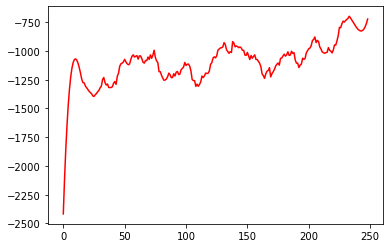

In [29]:
import numpy as np
from scipy.signal import savgol_filter
temp = [r[0][i][0] for i in range(len(r[0]))]
y = np.array(temp)
x = np.arange(len(y))
yhat = savgol_filter(y,31, 3) 

plt.plot(x, yhat, color='red')
plt.show()

In [87]:
from functools import reduce

import numpy as np
import torch

from active_learning.training_utils import get_reward
from sklearn.gaussian_process import GaussianProcessRegressor
from active_learning.observation_utils import augment_obs_posterior, get_posterior_no_prev, al_augment_obs
from network.vae_utils import loss_inference_closed_form
from ppo_a2c.algo.ppo import PPO
from ppo_a2c.envs import make_vec_envs_multi_task
from ppo_a2c.model import MLPBase, Policy
from ppo_a2c.storage import RolloutStorage

def train_identification(agent, n_iter, task_generator, env_name, seed, log_dir,
                         eval_interval, num_task_to_eval, gp_list, sw_size,
                         test_kwargs, max_id_iteration, num_test_processes, use_env_obs,
                         init_prior_test):
    eval_list = []
    test_list = []
    
    action_list = []
    reward_list = []

    for k in range(n_iter):
        envs_kwargs, _, prior_list, new_tasks = task_generator.sample_pair_tasks(agent.num_processes)

        envs = make_vec_envs_multi_task(env_name,
                                        seed,
                                        agent.num_processes,
                                        None,
                                        log_dir,
                                        agent.device,
                                        False,
                                        envs_kwargs,
                                        num_frame_stack=None)

        obs = envs.reset()
        obs = al_augment_obs(obs=obs, latent_dim=agent.latent_dim, posterior=prior_list,
                             prior=prior_list,
                             rescale_obs=agent.rescale_obs, max_old=agent.max_old,
                             min_old=agent.min_old)
        
        rollouts = RolloutStorage(agent.num_steps_id, agent.num_processes,
                                  agent.obs_shape_id, agent.action_space,
                                  agent.actor_critic_identification.recurrent_hidden_state_size)

        rollouts.obs[0].copy_(obs)
        rollouts.to(agent.device)

        use_prev_state = False

        # Collect observations and store them into the storage
        for step in range(agent.num_steps_id):
            # Sample actions
            with torch.no_grad():
                value, action, action_log_prob, recurrent_hidden_states = agent.actor_critic_identification.act(
                    rollouts.obs[step], rollouts.recurrent_hidden_states[step],
                    rollouts.masks[step])

            # Observe reward and next obs
            obs, reward, done, infos = envs.step(action)
            posterior = get_posterior_no_prev(agent.vae, action, reward, prior_list,
                                              use_prev_state=use_prev_state, max_action=agent.max_action,
                                              min_action=agent.min_action)
            action_list.append(action)
            reward_list.append(reward)
            use_prev_state = True
            reward = get_reward(posterior, new_tasks, agent.latent_dim, agent.num_processes)

            obs = al_augment_obs(obs=obs, latent_dim=agent.latent_dim, posterior=posterior,
                                 prior=prior_list,
                                 rescale_obs=agent.rescale_obs, max_old=agent.max_old,
                                 min_old=agent.min_old)

            # If done then clean the history of observations.
            if done.any():
                use_prev_state = False
            masks = torch.FloatTensor(
                [[0.0] if done_ else [1.0] for done_ in done])
            bad_masks = torch.FloatTensor(
                [[0.0] if 'bad_transition' in info.keys() else [1.0]
                 for info in infos])

            rollouts.insert(obs, recurrent_hidden_states, action,
                            action_log_prob, value, reward, masks, bad_masks)

        return action_list, reward_list, new_tasks[0], prior_list[0]
        with torch.no_grad():
            next_value = agent.actor_critic_identification.get_value(
                rollouts.obs[-1], rollouts.recurrent_hidden_states[-1],
                rollouts.masks[-1]).detach()

        rollouts.compute_returns(next_value, agent.use_gae, agent.gamma_identification,
                                 agent.gae_lambda, agent.use_proper_time_limits)

        _, _, _ = agent.agent_identification.update(rollouts)

        rollouts.after_update()

        if eval_interval is not None and k % eval_interval == 0 and k > 1:
            e = agent.evaluate_identification(num_task_to_eval=num_task_to_eval, task_generator=task_generator
                                             , seed=seed, env_name=env_name, log_dir=log_dir)
            eval_list.append(e)

            e = agent.meta_test(gp_list=gp_list, sw_size=sw_size, env_name=env_name, seed=seed,
                               log_dir=log_dir, envs_kwargs_list=test_kwargs,
                               init_prior=init_prior_test, use_env_obs=use_env_obs,
                               num_eval_processes=num_test_processes, max_id_iteration=max_id_iteration)
            test_list.append(e)

    return eval_list, test_list

In [96]:
a, r, task, prior = train_identification(agent, 1, task_generator, "gauss-v0", 0, ".",
                             20, 32, gp_list, 20,
                             test_kwargs, 30, 2, False,
                             init_prior_test)
r[0] = (100 - (-100)) / (1 - (-1)) * (action[i] - 1) + max_action
context = torch.cat([a[0], r[0]], 1)
context = context.reshape(1, context.shape[0], 2)
mean = agent.vae(context=context, prior=prior.flatten().reshape(1, 2))[1]
F.mse_loss(task, mean[0]).item()

103.37789154052734

In [102]:
F.mse_loss(task, prior[0])

tensor(32.7576)

In [108]:
r[0].mean()

tensor(0.1619)

tensor([34.8220])

In [34]:
import torch.nn.functional as F
m = 0
tot = 100
for _ in range(tot):
    data, _, prior, new = task_generator.sample_pair_tasks_data_loader(1)
    data = data[0][0]['train']
    y = data[1]
    idx = torch.where(y < 1)[0]
    y = y[idx]
    x = data[0][idx]
    x = x[0:30, :]
    y = y[0:30, :]
    context = torch.cat([x, y], 1)
    context = context.reshape(1, context.shape[0], 2)
    mean = agent.vae(context=context, prior=prior[0].flatten().reshape(1, 2))[1]
    m += F.mse_loss(new, mean).item()
print(m / tot)

2.8868500619661064
